In [20]:
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [21]:
#한글 깨짐 방지
from matplotlib import rc, font_manager
font_path='../data/fonts/malgun.ttf'
font_name=font_manager.FontProperties(fname=font_path).get_name()
rc('font',family=font_name)
#마이너스 깨짐 방지
plt.rcParams['axes.unicode_minus']=False

In [22]:
# temperature207=pd.read_csv('./data/temperature/207정선_월별.csv')
temperature207=pd.read_csv('../data/temperature/207정선_월별(30,50m).csv')
mackerel=pd.read_csv('../data/mackerel/부산_고등어_생산량(선어).csv',encoding='cp949')

df=pd.merge(temperature207,mackerel,on=['년도','월'])
# df.to_csv('data/merge/207_mackerel_product_final.csv',index=False,encoding='utf-8-sig')

In [23]:
merge_207=pd.read_csv('../data/merge/207_mackerel_product_final.csv')
# '%Y-%m' 형식으로 변환
merge_207['date'] = pd.to_datetime(merge_207['date'], format='%Y-%m-%d')

# 'date' 열을 인덱스로 설정
merge_207.set_index('date', inplace=True)

merge_207=merge_207[['수온(30m)','염분(30m)','용존산소(30m)','생산량']]
merge_207=merge_207.dropna()
merge_207.info()
merge_207

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 138 entries, 2008-01-01 to 2022-12-01
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   수온(30m)    138 non-null    float64
 1   염분(30m)    138 non-null    float64
 2   용존산소(30m)  138 non-null    float64
 3   생산량        138 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 5.4 KB


,수온(30m),염분(30m),용존산소(30m),생산량
date,,,,
2008-01-01,15.75,33.650,5.51500,7994
2008-02-01,14.80,34.010,5.82000,1430
2008-03-01,14.30,33.985,5.73500,3001
2008-07-01,15.10,33.940,5.13000,3946
2008-08-01,15.30,33.700,5.44000,7535
...,...,...,...,...
2022-08-01,20.00,32.820,3.87140,3900
2022-09-01,21.35,34.325,4.01425,5494
2022-10-01,21.70,33.030,4.45710,5339


In [24]:
seq_length=3 # 3~7사이 값 설정

train_size = int(len(merge_207)*0.9)
train_set=merge_207[0:train_size]
test_set=merge_207[train_size:]
print(train_set.shape,test_set.shape)

(124, 4) (14, 4)


In [25]:
train_set.head()

,수온(30m),염분(30m),용존산소(30m),생산량
date,,,,
2008-01-01,15.75,33.650,5.515,7994
2008-02-01,14.80,34.010,5.820,1430
2008-03-01,14.30,33.985,5.735,3001
2008-07-01,15.10,33.940,5.130,3946
2008-08-01,15.30,33.700,5.440,7535


In [26]:
#input scale
scaler_x=MinMaxScaler()
scaler_x.fit(train_set.iloc[:, :-1])

train_set.iloc[:, :-1]=scaler_x.transform(train_set.iloc[:, :-1])
test_set.iloc[:, :-1]=scaler_x.transform(test_set.iloc[:, :-1])

# output scale
scaler_y=MinMaxScaler()
scaler_y.fit(train_set.iloc[:,[-1]])
train_set.iloc[:, -1]=scaler_y.transform(train_set.iloc[:,[-1]])
test_set.iloc[:, -1]=scaler_y.transform(test_set.iloc[:,[-1]])

In [27]:
test_set[:]

,수온(30m),염분(30m),용존산소(30m),생산량
date,,,,
2021-08-01,0.518248,0.290657,0.185164,0.103563
2021-09-01,0.678832,0.486159,0.205329,0.278566
2021-10-01,0.766423,0.681661,0.507933,0.230392
2021-11-01,0.620438,0.747405,0.353672,0.338226
2021-12-01,0.401460,0.813149,0.448621,0.573654
2022-01-01,0.288321,0.858131,0.798700,0.275351
2022-02-01,0.175182,0.903114,0.733427,0.021648
2022-03-01,0.218978,0.885813,0.822437,0.048129
2022-07-01,0.554745,0.536332,0.413005,0.029403


In [28]:
import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset # 텐서데이터셋
from torch.utils.data import DataLoader # 데이터로더
import numpy as np

In [29]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(125)
if torch.cuda.is_available() :
    torch.cuda.manual_seed_all(125)

In [30]:
np.array(test_set)[:,[3]]

array([[0.103563  ],
       [0.27856581],
       [0.23039227],
       [0.33822637],
       [0.57365404],
       [0.27535124],
       [0.02164775],
       [0.04812858],
       [0.02940317],
       [0.0607171 ],
       [0.0965494 ],
       [0.09306508],
       [0.2561088 ],
       [0.52453636]])

In [31]:
def build_dataset(time_series, seq_length):
    dataX=[]
    dataY=[]
    for i in range(0, len(time_series)-seq_length):
        x_=time_series[i:i+seq_length, :]
        y_=time_series[i+seq_length,[3]]
        dataX.append(x_)
        dataY.append(y_)
    return np.array(dataX), np.array(dataY)

In [32]:
trainX, trainY=build_dataset(np.array(train_set), seq_length)
testX, testY=build_dataset(np.array(test_set),seq_length)

print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

(121, 3, 4) (121, 1)
(11, 3, 4) (11, 1)


In [33]:
trainX_tensor=torch.FloatTensor(trainX)
trainY_tensor=torch.FloatTensor(trainY)
testX_tensor=torch.FloatTensor(testX)
testY_tensor=torch.FloatTensor(testY)


print(trainX_tensor.size(), trainY_tensor.size())
print(testX_tensor.size(), testY_tensor.size())

torch.Size([121, 3, 4]) torch.Size([121, 1])
torch.Size([11, 3, 4]) torch.Size([11, 1])


In [34]:
train_dataset=TensorDataset(trainX_tensor, trainY_tensor)
train_loader=DataLoader(train_dataset, shuffle=True,
                        drop_last=True)

In [35]:
data_dim=3
hidden_dim=6
output_dim=1
learning_late=0.01
epochs=2000

In [36]:
class Net(nn.Module):
  def __init__(self, input_dim, hidden_dim, seq_length, output_dim, layers):
    super(Net, self).__init__()
    self.hidden_dim=hidden_dim
    self.seq_length=seq_length
    self.output_dim=output_dim
    self.layers=layers

    self.lstm=nn.LSTM(input_dim, 
                      hidden_dim, 
                      num_layers=layers,
                      batch_first=True)
    
    self.fc=nn.Linear(hidden_dim, output_dim, bias=True)
    self.relu = nn.ReLU()

  def reset_hidden_state(self):
    self.hidden=(
      torch.zeros(self.layers, self.seq_length, self.hidden_dim),
      torch.zeros(self.layers, self.seq_length, self.hidden_dim)
    )
  def forward(self, x):
    x, _status=self.lstm(x)
    x=self.fc(x[:, -1])
    x = self.relu(x)  # ReLU 추가
    return x

In [37]:
def train_model(model, train_df, epochs=None, lr=None, verbos=10, patience=10):
  criterion=nn.MSELoss().to(device)
  optimizer=optim.Adam(model.parameters())
  n_epochs=epochs

  train_hist=np.zeros(n_epochs)
  for epoch in range(n_epochs):
    avg_cost=0
    total_batch=len(train_df)

    for batch_idxm, sample in enumerate(train_df):
      x_train, y_train=sample
      model.reset_hidden_state()
      output=model(x_train)
      loss=criterion(output, y_train)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      avg_cost+=loss/total_batch
    
    train_hist[epoch]=avg_cost

    if epoch % verbos==0:
      print('Epoch:{}, train_loss:{}'.format(epoch, avg_cost.item()))

    if(epoch % patience==0) & (epoch!=0):
      if train_hist[epoch-patience] < train_hist[epoch]:
        print("Early Stopping")
        break
  return model.eval(), train_hist

In [38]:
net=Net(data_dim, hidden_dim, seq_length, output_dim, 1)
model, train_hist=train_model(net, train_loader, epochs=epochs,
                              lr=learning_late, verbos=20, patience=100)

AttributeError: 'Net' object has no attribute 'relu'

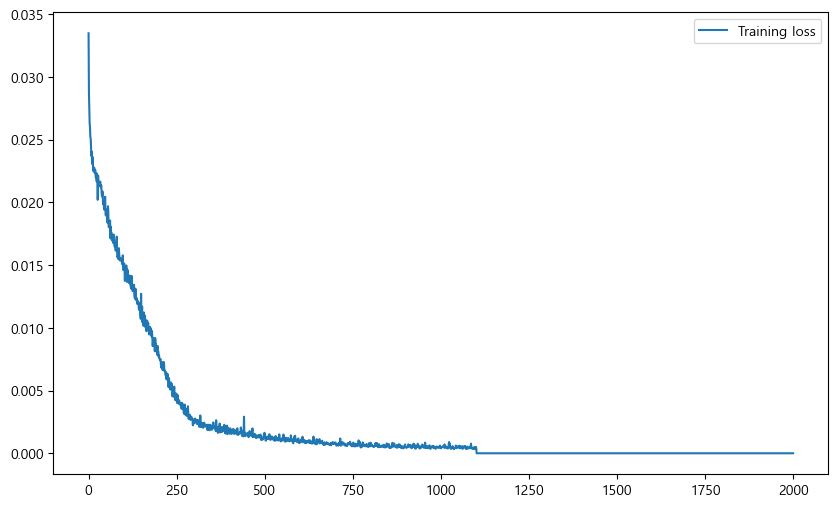

In [ ]:
fig=plt.figure(figsize=(10, 6))
plt.plot(train_hist, label='Training loss')
plt.legend()
plt.show()

In [ ]:
# path="../model/product_final.pth"

# torch.save(model.state_dict(), path)

In [ ]:
# model=Net(data_dim, hidden_dim, seq_length, output_dim, 1).to(device)
# model.load_state_dict(torch.load(path), strict=False)
# model.eval()

Net(
  (lstm): LSTM(7, 14, batch_first=True)
  (fc): Linear(in_features=14, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:

with torch.no_grad():
    pred=[]
    for pr in range(len(testX_tensor)):
        model.reset_hidden_state()
        predicted=model(torch.unsqueeze(testX_tensor[pr],0))
        predicted=torch.flatten(predicted).item()
        pred.append(predicted)

    pred_inverse=scaler_y.inverse_transform(np.array(pred).reshape(-1, 1))
    testY_inverse=scaler_y.inverse_transform(testY_tensor)

def MAE(true, pred):
    return np.mean(np.abs(true-pred))


print('MAe SCORE:', MAE(pred_inverse, testY_inverse))

MAe SCORE: 1387.7369481147348


In [ ]:
test_set.index[seq_length:]

DatetimeIndex(['2021-11-01', '2021-12-01', '2022-01-01', '2022-02-01',
               '2022-03-01', '2022-07-01', '2022-08-01', '2022-09-01',
               '2022-10-01', '2022-11-01', '2022-12-01'],
              dtype='datetime64[ns]', name='date', freq=None)

In [ ]:
date=['2021-10','2021-11', '2021-12','2022-01', '2022-02', 
      '2022-03','2022-08', '2022-09', '2022-10', '2022-11','2022-12']

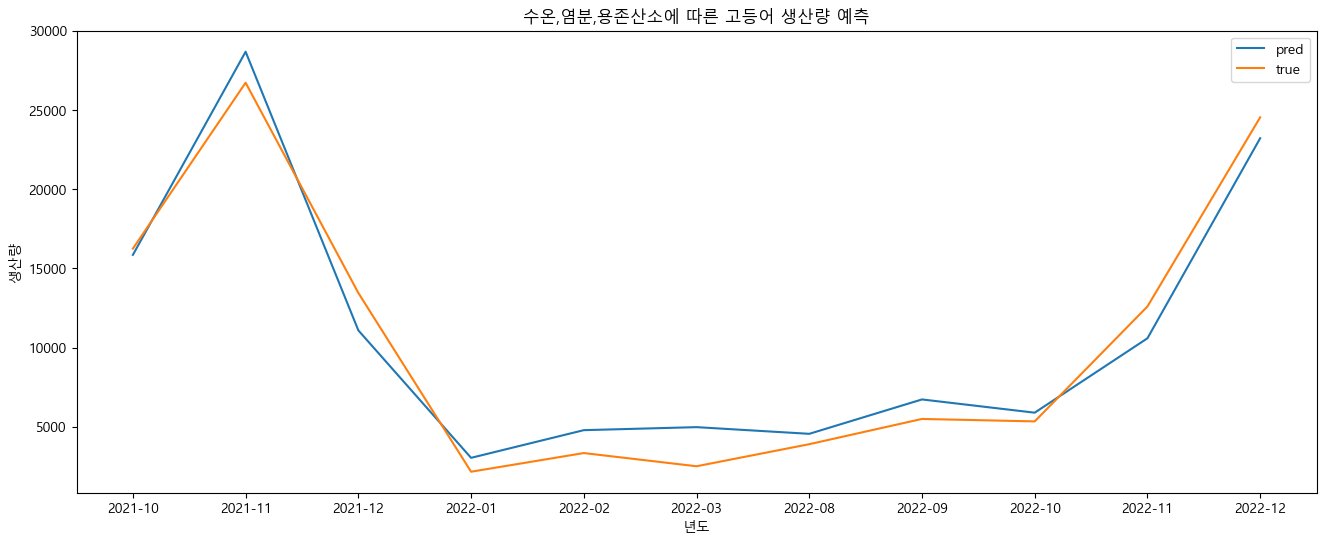

In [ ]:
fig=plt.figure(figsize=(16,6))
plt.title('수온,염분,용존산소에 따른 고등어 생산량 예측')
plt.plot(np.arange(len(pred_inverse)), pred_inverse, label='pred')
plt.plot(np.arange(len(testY_inverse)), testY_inverse, label='true')
plt.xlabel('년도')
plt.ylabel('생산량')

plt.xticks(np.arange(len(pred_inverse)),date)
plt.legend()
plt.show()

In [ ]:
pred_inverse

array([[15851.88716227],
       [28674.71356982],
       [11085.11244686],
       [ 3038.58830245],
       [ 4785.59042425],
       [ 4975.8894852 ],
       [ 4554.41166745],
       [ 6724.9186884 ],
       [ 5889.1340688 ],
       [10585.05042376],
       [23214.09036839]])

# 모델활용 미래 예측
 - 수온에 따른 고등어 생산량(23~24) 예측

In [ ]:
# 데이터 불러오기
pred_product=pd.read_csv('../data/merge/product_pred_values.csv')

pred_product['date'] = pd.to_datetime(pred_product['date'], format='%Y-%m-%d')

# 'date' 열을 인덱스로 설정
pred_product.set_index('date', inplace=True)
pred_product=pred_product[['수온(30m)','염분(30m)','용존산소(30m)','수온(50m)','염분(50m)','용존산소(50m)']]
pred_product

,수온(30m),염분(30m),용존산소(30m),수온(50m),염분(50m),용존산소(50m)
date,,,,,,
2023-10-01,20.798988,33.406807,4.851332,22.469068,33.502672,4.395779
2023-11-01,19.373635,33.949312,5.027594,19.891051,33.757995,4.687205
2023-12-01,18.191672,34.440692,5.227121,17.208053,34.018400,4.941705
2024-01-01,16.847143,34.500956,5.559471,15.561030,34.273341,5.513203
2024-02-01,15.351883,34.693340,6.007755,14.003451,34.530587,6.031051
2024-03-01,16.113682,34.636485,5.985635,14.308045,34.507189,5.844387
2024-07-01,18.218405,33.826171,4.961626,16.719163,34.101989,4.423673
2024-08-01,19.224562,33.677034,4.610592,18.867211,34.117744,4.067731
2024-09-01,19.656216,33.256991,4.516618,19.931958,33.988613,3.947314


In [ ]:
#input scale
pred_product=scaler_x.transform(pred_product)

In [ ]:
def build_pred_dataset(time_series, seq_length):
    dataX=[]
    for i in range(0, len(time_series)-seq_length):
        x_=time_series[i:i+seq_length, :]
        dataX.append(x_)
    return np.array(dataX)

In [ ]:
predX=build_pred_dataset(np.array(pred_product),seq_length)
predX.shape

(12, 3, 6)

In [ ]:
predX_tensor=torch.FloatTensor(predX)

In [ ]:
# path="../model/product_final.pth"
# model=Net(data_dim, hidden_dim, seq_length, output_dim, 1).to(device)
# model.load_state_dict(torch.load(path), strict=False)
# model.eval()

Net(
  (lstm): LSTM(7, 14, batch_first=True)
  (fc): Linear(in_features=14, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
with torch.no_grad():
    pred=[]
    for pr in range(len(predX_tensor)):
        model.reset_hidden_state()
        predicted=model(torch.unsqueeze(predX_tensor[pr],0))
        predicted=torch.flatten(predicted).item()
        pred.append(predicted)

    pred_inverse=scaler_y.inverse_transform(np.array(pred).reshape(-1, 1))

In [ ]:
date=['2023-07','2023-08','2023-09','2023-10','2023-11','2023-12',
      '2024-01','2024-02', '2024-03','2023-04','2024-05','2024-06',
      ]

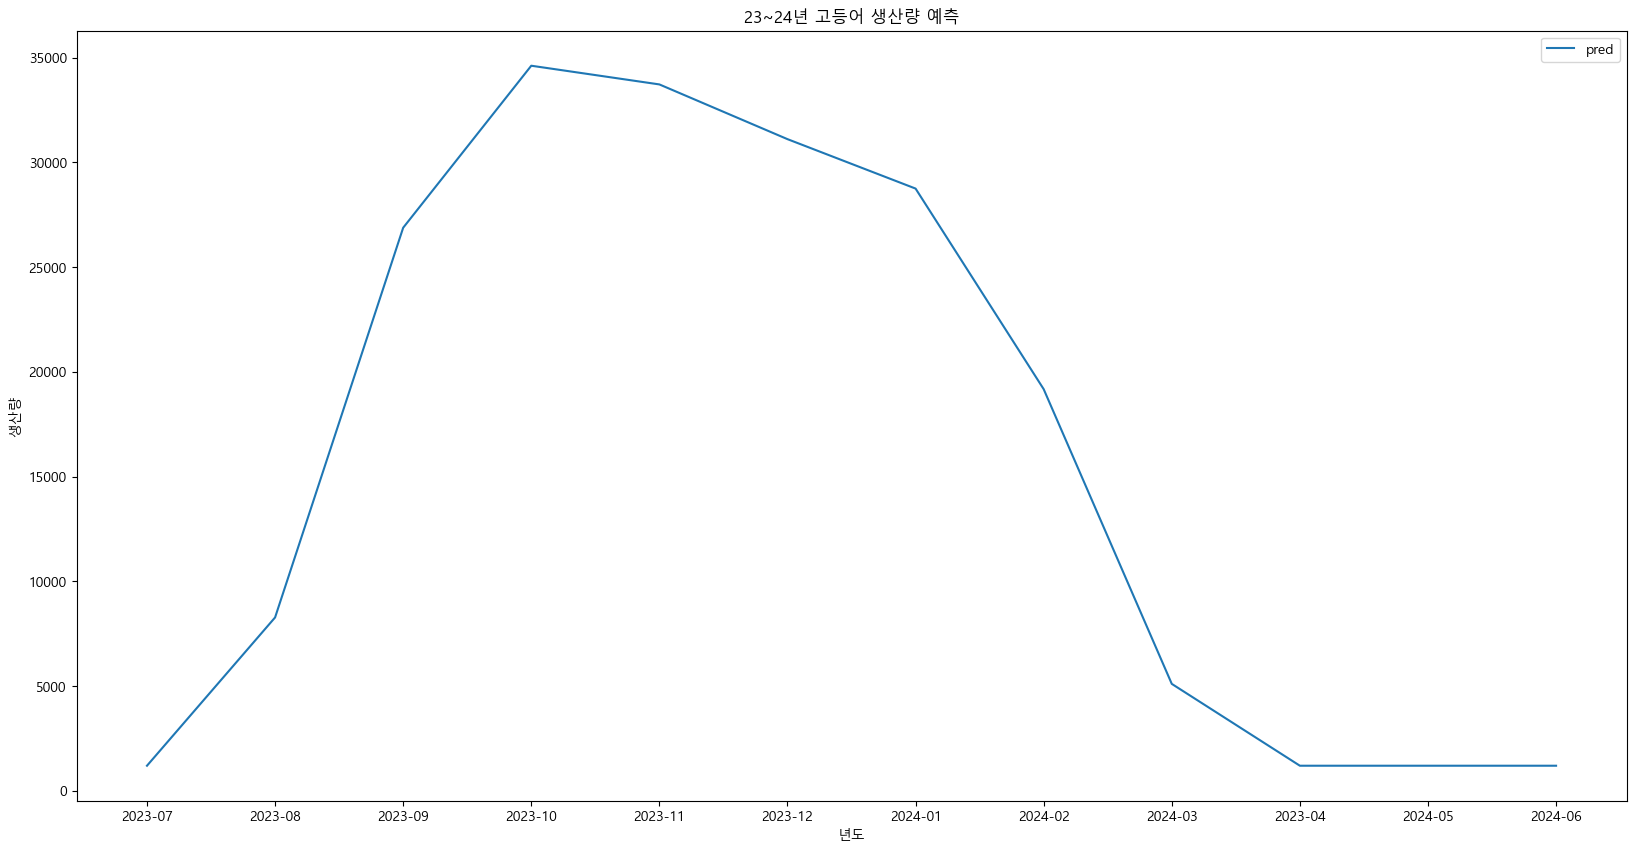

In [ ]:
fig=plt.figure(figsize=(20,10))
plt.title('23~24년 고등어 생산량 예측')
plt.plot(np.arange(len(pred_inverse)), pred_inverse, label='pred')
plt.xlabel('년도')
plt.ylabel('생산량')

plt.xticks(np.arange(len(pred_inverse)),date)
plt.legend()
plt.show()

In [ ]:
pred_inverse

array([[20914.8948338 ],
       [17031.57429481],
       [ 5503.72809166],
       [ 1199.        ],
       [ 1199.        ],
       [ 1199.        ],
       [ 1199.        ],
       [ 1199.        ],
       [ 8351.39166379],
       [12549.69731906],
       [11265.32051364],
       [ 4956.46118933],
       [ 1199.        ],
       [ 1199.        ],
       [ 1199.        ]])

In [ ]:
pd.DataFrame(pred_inverse).to_csv('../data/pred/product_pred.csv',index=False,encoding='utf-8-sig')